# Modelling and Evaluation Notebook

## Objectives

* Answer business requirement 2
* * The client is interested to tell whether a given cell contains a malaria parasite or not.

## Inputs

* input/Apple_vs_Orange/test/Apple
* input/Apple_vs_Orange/test/Orange
* input/Apple_vs_Orange/train/Apple
* input/Apple_vs_Orange/train/Orange
* input/Apple_vs_Orange/validation/Apple
* input/Apple_vs_Orange/validation/Orange

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Additional Comments | Insights | Conclusions

---

# Import regular packages

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set working directory

In [10]:
cwd = os.getcwd()

In [11]:
os.chdir('/workspaces/CI_PP5_Apples')
print("You set a new current directory")

You set a new current directory


In [12]:
work_dir = os.getcwd()
work_dir

'/workspaces/CI_PP5_Apples'

---

# Set input directory

Set train, test, and validation paths

In [13]:
my_data_dir = 'input/Apple_vs_Orange/'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

# Set output directory

In [14]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


# Set labels

In [15]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['Apple', 'Orange']


# Set image shape

In [16]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(850, 644, 3)

---

# Number of images in train, test and validation data

* train - Apple: 125 images
* train - Orange: 107 images
* validation - Apple: 17 images
* validation - Orange: 15 images
* test - Apple: 37 images
* test - Orange: 31 images




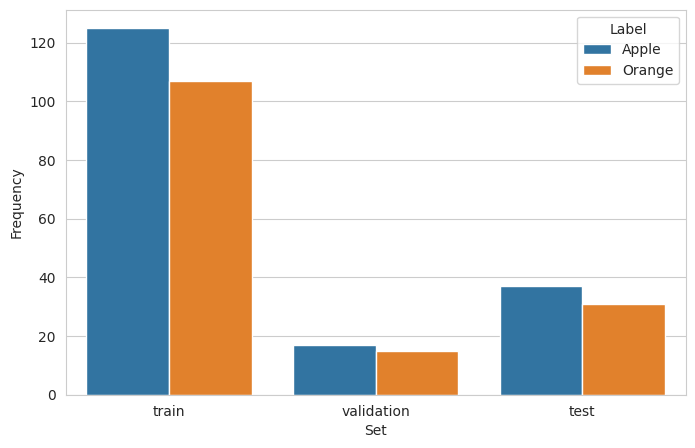

In [17]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

---

## ImageDataGenerator

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* # Initialize ImageDataGenerator

In [19]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

* # Augment training image dataset

In [20]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 232 images belonging to 2 classes.


{'Apple': 0, 'Orange': 1}

* # Augment validation image dataset

In [21]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 32 images belonging to 2 classes.


{'Apple': 0, 'Orange': 1}

* # Augment test image dataset

In [22]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 68 images belonging to 2 classes.


{'Apple': 0, 'Orange': 1}

# Plot augmented training image

(20, 850, 644, 3)


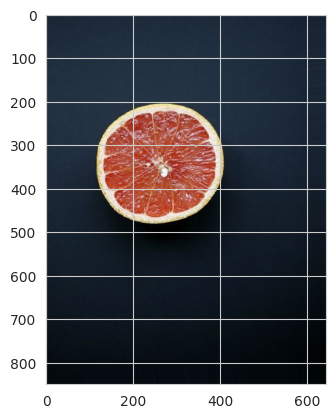

(20, 850, 644, 3)


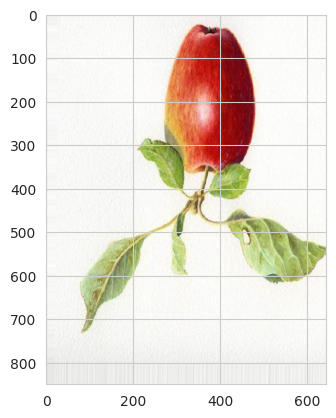

(20, 850, 644, 3)


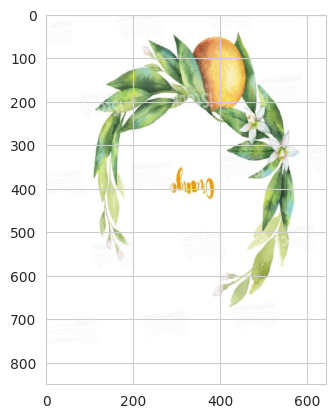

In [23]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

# Plot augmented validation and test images

(20, 850, 644, 3)


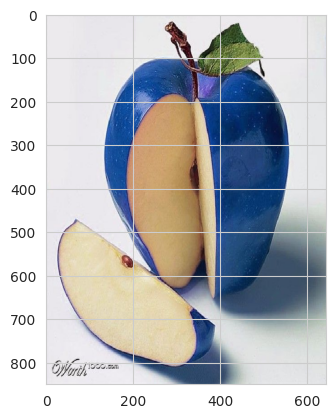

(12, 850, 644, 3)


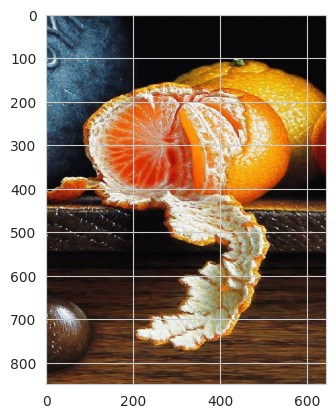

(20, 850, 644, 3)


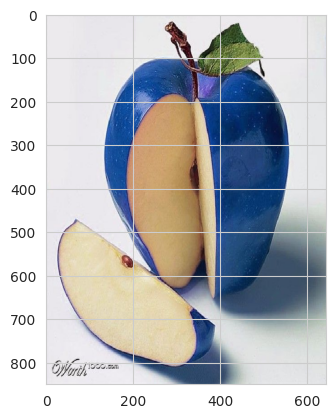

In [24]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 850, 644, 3)


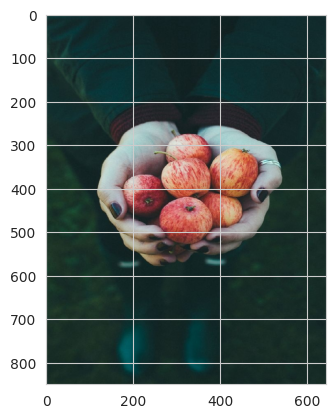

(20, 850, 644, 3)


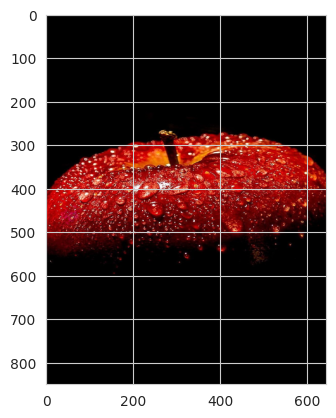

(20, 850, 644, 3)


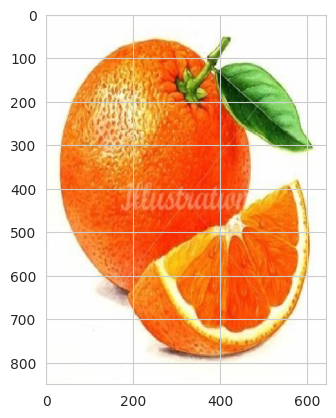

In [25]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

# Save class_indices

In [26]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model Creation

---

## ML Model

* ## Import Model Packages

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ## Model

In [28]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

* ## Model Summary

In [29]:
create_tf_model().summary()

2024-02-08 11:44:19.702740: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 848, 642, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 424, 321, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 422, 319, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 211, 159, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 209, 157, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 104, 78, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 519168)            0

* ## Early Stopping

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit model for model training

In [ ]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2024-02-08 11:46:31.772281: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2024-02-08 11:47:08.785255: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1393704960 exceeds 10% of free system memory.
2024-02-08 11:47:25.402163: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 689244160 exceeds 10% of free system memory.


## Save model

In [ ]:
model.save('outputs/v1/malaria_detector_model.h5')

---

# Model Performance

---